# CatGAN

## Install and Import Dependencies

In [1]:
download = False
if download:
    !git clone https://github.com/DennisRotondi/visiope_project
    %cd visiope_project
    !pip3 install -r requirements.txt

import os
import random
import numpy as np
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import PIL
from PIL import Image,ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import dataclasses
from dataclasses import dataclass
from dataclasses import asdict
from pprint import pprint
from typing import Sequence, List, Dict, Tuple, Optional, Any, Set, Union, Callable, Mapping

np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

## Dataset Handling

In [2]:
class CatDataset(Dataset):
    
    def __init__(self, 
                 folder, 
                 transform = None
        ):
        
        super().__init__()
        self.folder = Path(folder)
        assert(self.folder.is_dir())
        self.files = list(sorted(self.folder.rglob('*.jpg')))
        assert(self.files)
        self.files_num = len(self.files)
        self.transform = transform

    def __len__(self):
        return self.files_num

    def pil_loader(self,file):
        with file.open('rb') as f:
            img = PIL.Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
        file = self.files[index % self.files_num]
        image = self.pil_loader(file)

        if self.transform is not None:
            image = self.transform(image)
        
        return {
            'file': image,
            'path': str(file)
        }
        
def plot_cats(images, 
                images_per_row, 
                border = 10, 
                pad_value = 1,
                title = 'Cats images',
                figsize = (16,16)):
    plt.figure(figsize = figsize)
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

visualize some cats from the dataset

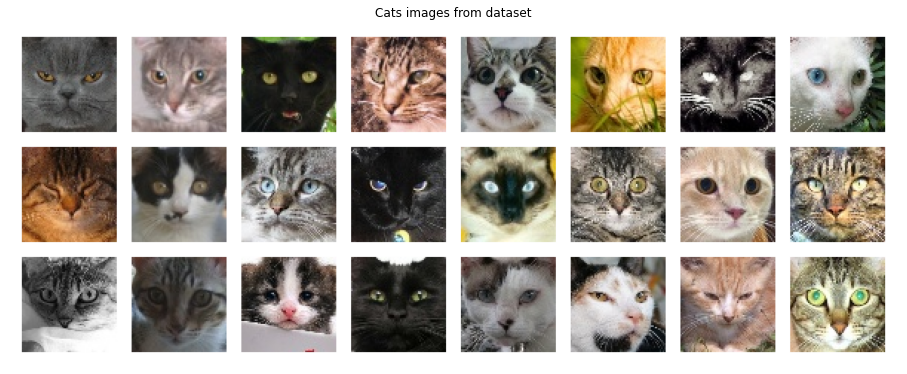

In [6]:
path = "./cats"

catsData = DataLoader(
    CatDataset(
        path,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=24,
    shuffle=True,
)
batch = iter(catsData).next()
plot_cats(batch["file"], images_per_row=8, title="Cats images from dataset")

## GAN Model

### Hyperparameters

In [3]:
@dataclass
class Hparams:
    img_height: int = 64  # size of image height # default 256x256
    img_width: int = 64  # size of image width
    batch_size: int = 256  # size of the batches
    lrg: float = 2e-4  # optimizer: learning rate for generator
    lrd: float = 2e-4  # optimizer: learning rate for discriminator
    betag: float = 0.5  # optimizer: beta parameter for generator
    betad: float = 0.5  # optimizer: beta parameter for discriminator
    channels: int = 3  # number of image channels
    n_cpu: int = 8  # number of cpu threads to use for the dataloaders
    latent_dim: int = 128 # size of the gaussian noise to generate the image
hparams = asdict(Hparams())
pprint(hparams)

{'batch_size': 256,
 'betad': 0.5,
 'betag': 0.5,
 'channels': 3,
 'img_height': 64,
 'img_width': 64,
 'latent_dim': 128,
 'lrd': 0.0002,
 'lrg': 0.0002,
 'n_cpu': 8}


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, 3,padding='same'),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self,hparams):
        super(Generator, self).__init__()
        self.hparams = hparams
        self.img_shape = (hparams['channels'], hparams['img_height'], hparams['img_width'])
        def gan_block_tcnn(in_features, out_features, kernel_size,stride,padding,bias, residual=False, normalize = True):
            layer = [nn.ConvTranspose2d(in_features, out_features, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            if normalize:
                layer += [nn.BatchNorm2d(out_features)]
            layer += [nn.LeakyReLU(0.3, inplace = True)]
            if residual:
                layer += [ResidualBlock(out_features)] 
            return layer

        self.model = nn.Sequential(
            *gan_block_tcnn(self.hparams['latent_dim'], 512, kernel_size=4,stride=1,padding=0,bias=False, residual=False),
            *gan_block_tcnn(512, 256, kernel_size=4, stride=2, padding=1, bias=False, residual=False),
            *gan_block_tcnn(256, 128, kernel_size=4, stride=2, padding=1, bias=False, residual=False),
            *gan_block_tcnn(128, 64, kernel_size=4, stride=2, padding=1, bias=False, residual=False),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            ResidualBlock(3),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        def gan_block_cnn(in_features, out_features, kernel_size,stride, padding, bias=False, slope=0, normalize=False, residual=False):
            layer = [nn.Conv2d(in_features, out_features, kernel_size, stride, padding, bias=bias),]
            if normalize:
                layer += [nn.BatchNorm2d(out_features)]
            if slope != 0:
                layer += [nn.LeakyReLU(slope, inplace = True)]
            if residual:
                layer += [ResidualBlock(out_features)]     
            return layer

        self.model = nn.Sequential(
            *gan_block_cnn(3,64,kernel_size=4,stride=2,padding=1,slope=0.2,normalize=False),
            *gan_block_cnn(64,128,kernel_size=4,stride=2,padding=1,slope=0.2,normalize=True),
            *gan_block_cnn(128,256,kernel_size=4,stride=2,padding=1,slope=0.2,normalize=True,residual=False),
            *gan_block_cnn(256,256,kernel_size=5,stride=1,padding='same',slope=0.2,normalize=False),
            *gan_block_cnn(256,512,kernel_size=4,stride=2,padding=1,slope=0.2,normalize=True, residual=False),
            *gan_block_cnn(512,1,kernel_size=4,stride=1,padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [8]:
#test to check if they produce the right shape
dis = Discriminator(hparams)
print(batch['file'].shape)
l=dis(batch['file'])
print(l.shape)

gen = Generator(hparams)
zz = torch.randn(3, hparams['latent_dim'],1,1)
print(zz.shape)
gimg = gen(zz)
print(gimg.shape)

# print(dis)
# print(gen)

torch.Size([24, 3, 64, 64])
torch.Size([24, 1])
torch.Size([3, 128, 1, 1])
torch.Size([3, 3, 64, 64])


## Training

In [9]:
class CatGAN_Trainer():
    def __init__(
        self,
        generator,
        discriminator,
        loss_function,
        optimizer_g,
        optimizer_d,
        device,
        hparams,
        log_steps:int=10, #how many epochs save images to plot (using valid_samples)
        log_level:int=2):

        self.device = device
        self.generator = generator
        self.discriminator = discriminator
        #https://pytorch.org/docs/master/generated/torch.nn.Module.html?highlight=apply#torch.nn.Module.apply
        self.generator.apply(self.weights_init_normal)
        self.discriminator.apply(self.weights_init_normal)
        self.generator.to(self.device)
        self.discriminator.to(self.device)

        self.loss_function = loss_function
        self.optimizer_g = optimizer_g
        self.optimizer_d = optimizer_d
        
        self.hparams = hparams
        self.log_steps = log_steps
        self.log_level = log_level
        
        self.valid_samples = torch.randn(8, self.hparams['latent_dim'],1,1).to(self.device)
        self.gen_train_loss = list()
        self.dis_fake_loss = list()
        self.dis_real_loss = list()
        self.training_imgs = list()
        #https://arxiv.org/pdf/2002.06224.pdf
        self.k = hparams['batch_size']
        self.decay_value = 0.98
        self.min_k = int(hparams['batch_size']*0.60)
    #to apply the weights initialization
    def weights_init_normal(self, m: nn.Module):
        classname = m.__class__.__name__
        #following cycle-gan paper
        if classname.find("Conv") != -1 or classname.find("Linear") != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
            if hasattr(m, "bias") and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
        elif classname.find("BatchNorm2d") != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)
    #to invert the normalization of the compose transform.
    def denormalize(self,tensor):
        return tensor*0.5 + 0.5
    #main training loop
    def train(self, train_dataset:Dataset, epochs:int=1):
        assert epochs > 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')    
        for epoch in range(epochs):
            if self.log_level > 0:
                print(' Epoch {:03d}'.format(epoch))
            epoch_gen_loss = 0.0
            epoch_dis_fake_loss = 0.0
            epoch_dis_real_loss = 0.0
            self.generator.train()
            self.discriminator.train()
            # for each batch 
            for step, sample in enumerate(train_dataset):
                imgs = sample['file'].to(self.device)
                # sample noise
                z = torch.randn(imgs.shape[0], *self.valid_samples.shape[1:]).type_as(imgs).to(self.device)
                self.optimizer_g.zero_grad()
                ## train generator
                # generate images
                generated_imgs = self.generator(z) #! log sampled images if you want
                # to train the generator we have to follow the direction in which the
                # discriminator classifies fake images as real
                predictions = self.discriminator(generated_imgs)
                topk_predictions = torch.topk(predictions, min(self.k,imgs.shape[0]),0).values
                topk_valid = torch.ones_like(topk_predictions).type_as(imgs)
                g_loss = self.loss_function(topk_predictions, topk_valid)
                epoch_gen_loss += g_loss
                g_loss.backward()
                self.optimizer_g.step()
                self.optimizer_d.zero_grad()
                ## train discriminator
                # we train on real images to be discriminated as real
                valid = torch.ones(imgs.size(0), 1).type_as(imgs)
                #if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3
                #(r2 - r1) * torch.rand(a, b) + r1 -> to have a "segment" between those values
                valid_noise = (0.2 + 0.2) * torch.rand(imgs.size(0), 1).type_as(imgs) - 0.2 #to have a perturbation in [-0.3,0.2]
                fake_noise = 0.2 * torch.rand(imgs.size(0), 1).type_as(imgs)
                real_loss = self.loss_function(self.discriminator(imgs), valid+valid_noise)
                epoch_dis_real_loss += real_loss
                # we train of fake images to be discriminated as fake
                fake = torch.zeros(imgs.size(0), 1).type_as(imgs)
                # need detach here to avoid double graph propagation during the backward step
                fake_loss = self.loss_function(self.discriminator(generated_imgs.detach()), fake+fake_noise)
                epoch_dis_fake_loss += fake_loss
                # discriminator loss is the sum of these
                d_loss = (real_loss + fake_loss)/2
                d_loss.backward()
                self.optimizer_d.step()
            #update k value
            self.k = int(max(self.min_k,self.k*self.decay_value))
            self.gen_train_loss.append(epoch_gen_loss.tolist()) #to save a mean loss of it
            self.dis_fake_loss.append(epoch_dis_fake_loss.tolist())
            self.dis_real_loss.append(epoch_dis_real_loss.tolist())
            if (epoch+1) % self.log_steps == 0:
                sample_imgs = self.generator(self.valid_samples)
                grid = torchvision.utils.make_grid(self.denormalize(sample_imgs.cpu()),4,10,1).permute(1, 2, 0)
                self.training_imgs.append(grid)
            if self.log_level > 0:
                print('\t[E: {:2d}] gen train loss = {:0.4f}'.format(epoch, epoch_gen_loss))
                print('\t[E: {:2d}] dis fake loss = {:0.4f}'.format(epoch, epoch_dis_fake_loss))
                print('\t[E: {:2d}] dis real loss = {:0.4f}'.format(epoch, epoch_dis_real_loss))
        if self.log_level > 0:
            print('... Done!')

In [10]:
generator = Generator(hparams)
discriminator = Discriminator(hparams)
optimizer_g = optim.Adam(generator.parameters(), lr=hparams['lrg'], betas=(hparams['betag'], 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=hparams['lrd'], betas=(hparams['betad'], 0.999))
# loss = F.binary_cross_entropy
loss = nn.BCELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
train_folder = "./cats"
image_transforms = transforms.Compose(
            [   
                transforms.Resize(hparams['img_height']),
                transforms.CenterCrop(hparams['img_height']),
                transforms.ToTensor(),
                #to have 0 mean and values in range [-1, 1]
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ]
        )

train_loader = DataLoader(
            CatDataset(
                train_folder, transform=image_transforms
            ),
            batch_size = hparams['batch_size'],
            shuffle=True,
            num_workers = hparams['n_cpu'],
            pin_memory=True
        )

catGAN_T = CatGAN_Trainer(generator,discriminator,loss,optimizer_g,optimizer_d,device,hparams)


cuda


In [115]:
catGAN_T.train(train_loader, 51)

Training ...
 Epoch 000
	[E:  0] gen train loss = 338.4331
	[E:  0] dis fake loss = 53.0866
	[E:  0] dis real loss = 8.6123
 Epoch 001
	[E:  1] gen train loss = 191.6297
	[E:  1] dis fake loss = 32.5457
	[E:  1] dis real loss = 7.4966
 Epoch 002
	[E:  2] gen train loss = 145.0242
	[E:  2] dis fake loss = 29.9670
	[E:  2] dis real loss = 8.6940
 Epoch 003
	[E:  3] gen train loss = 127.7939
	[E:  3] dis fake loss = 35.0323
	[E:  3] dis real loss = 13.9569
 Epoch 004
	[E:  4] gen train loss = 122.2740
	[E:  4] dis fake loss = 35.1683
	[E:  4] dis real loss = 14.4289
 Epoch 005
	[E:  5] gen train loss = 118.7332
	[E:  5] dis fake loss = 37.3195
	[E:  5] dis real loss = 14.8629
 Epoch 006
	[E:  6] gen train loss = 101.9458
	[E:  6] dis fake loss = 33.3984
	[E:  6] dis real loss = 15.7545
 Epoch 007
	[E:  7] gen train loss = 133.3594
	[E:  7] dis fake loss = 33.6282
	[E:  7] dis real loss = 12.3038
 Epoch 008
	[E:  8] gen train loss = 110.1367
	[E:  8] dis fake loss = 32.7166
	[E:  8] dis re

### Plot results of traning

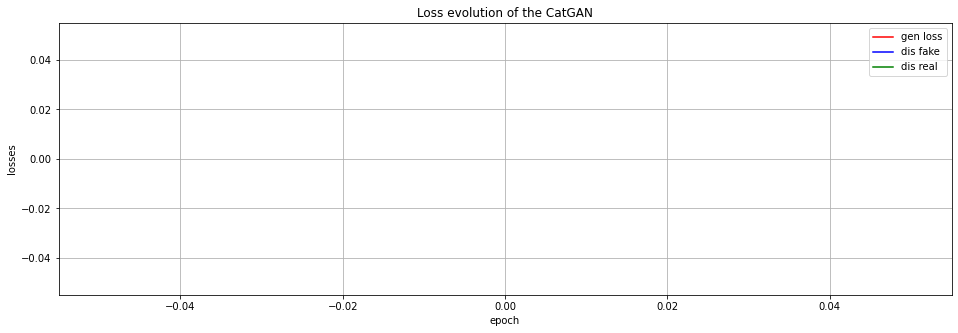

In [14]:
X=np.arange(len(catGAN_T.gen_train_loss))

plt.figure(figsize=(16,5))
plt.plot(X, catGAN_T.gen_train_loss, color='r', label='gen loss')
plt.plot(X, catGAN_T.dis_fake_loss, color='b', label='dis fake')
plt.plot(X, catGAN_T.dis_real_loss, color='g', label='dis real')

plt.xlabel("epoch")
plt.ylabel("losses")
plt.title("Loss evolution of the CatGAN")
plt.legend()
plt.grid()
plt.show()

for idx,grid in enumerate(catGAN_T.training_imgs):
    plt.figure(figsize = (16, 16))
    inp = np.clip(grid, 0, 1)
    plt.imshow(inp)
    plt.title("Cats after {} epochs".format((idx+1)*catGAN_T.log_steps))
    plt.axis('off') 

## Utilities

### Save Model

In [11]:
model_path_save = 'CatGANv55.pth'
torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
            }, model_path_save)

### Load Model

In [12]:
model_path_load = 'CatGANv5.pth'
checkpoint = torch.load(model_path_load,map_location=device)
generator.load_state_dict(checkpoint['generator'])
discriminator.load_state_dict(checkpoint['discriminator'])
optimizer_g.load_state_dict(checkpoint['optimizer_g'])
optimizer_d.load_state_dict(checkpoint['optimizer_d'])

### Visualize best, medium and low quality samples that the generator've learned to produce.

In [17]:
best = list()
medium = list()
low = list()

while(len(best)<24):
    z = torch.randn(30, hparams['latent_dim'],1,1).to(device)
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        imgs = generator(z)
        pred = discriminator(imgs)
        best_idx = (pred > 0.8).view(-1)
        medium_idx = (torch.logical_and(pred > 0.5,pred < 0.8)).view(-1)
        low_idx = (pred < 0.3).view(-1)
        best_imgs = imgs[best_idx,...]
        medium_imgs = imgs[medium_idx,...]
        low_imgs = imgs[low_idx,...]
        if len(best_imgs) != 0:
            best.append(best_imgs)
            # print(len(best))
        if len(medium_imgs) != 0:
            medium.append(medium_imgs)
        if len(low_imgs) != 0:
            low.append(low_imgs)
print(len(best), len(medium), len(low))

24 1836 3652


torch.Size([24, 3, 64, 64]) torch.Size([24, 3, 64, 64]) torch.Size([24, 3, 64, 64])


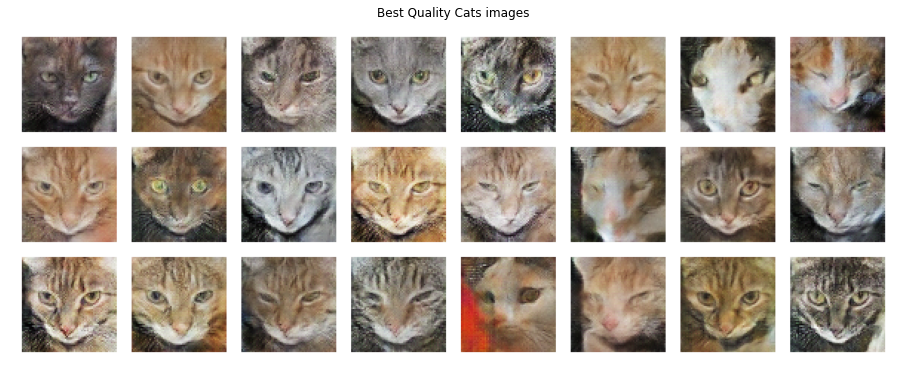

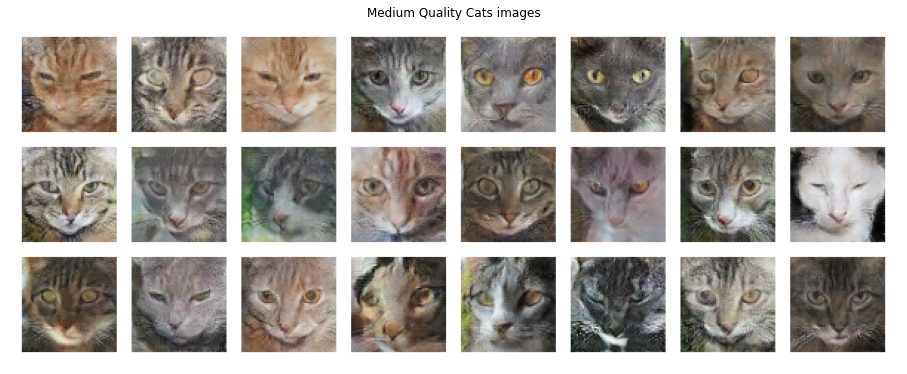

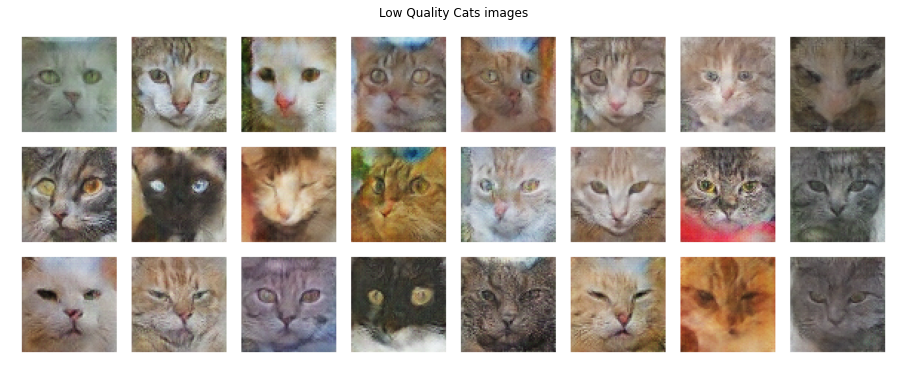

In [18]:
best_imgs = torch.cat(best, dim=0)[:24,...].cpu()
medium_imgs = torch.cat(medium, dim=0)[:24,...].cpu()
low_imgs = torch.cat(low, dim=0)[:24,...].cpu()
print(best_imgs.shape,medium_imgs.shape,low_imgs.shape)

plot_cats(catGAN_T.denormalize(best_imgs), images_per_row=8, title="Best Quality Cats images")
plot_cats(catGAN_T.denormalize(medium_imgs), images_per_row=8, title="Medium Quality Cats images")
plot_cats(catGAN_T.denormalize(low_imgs), images_per_row=8, title="Low Quality Cats images")

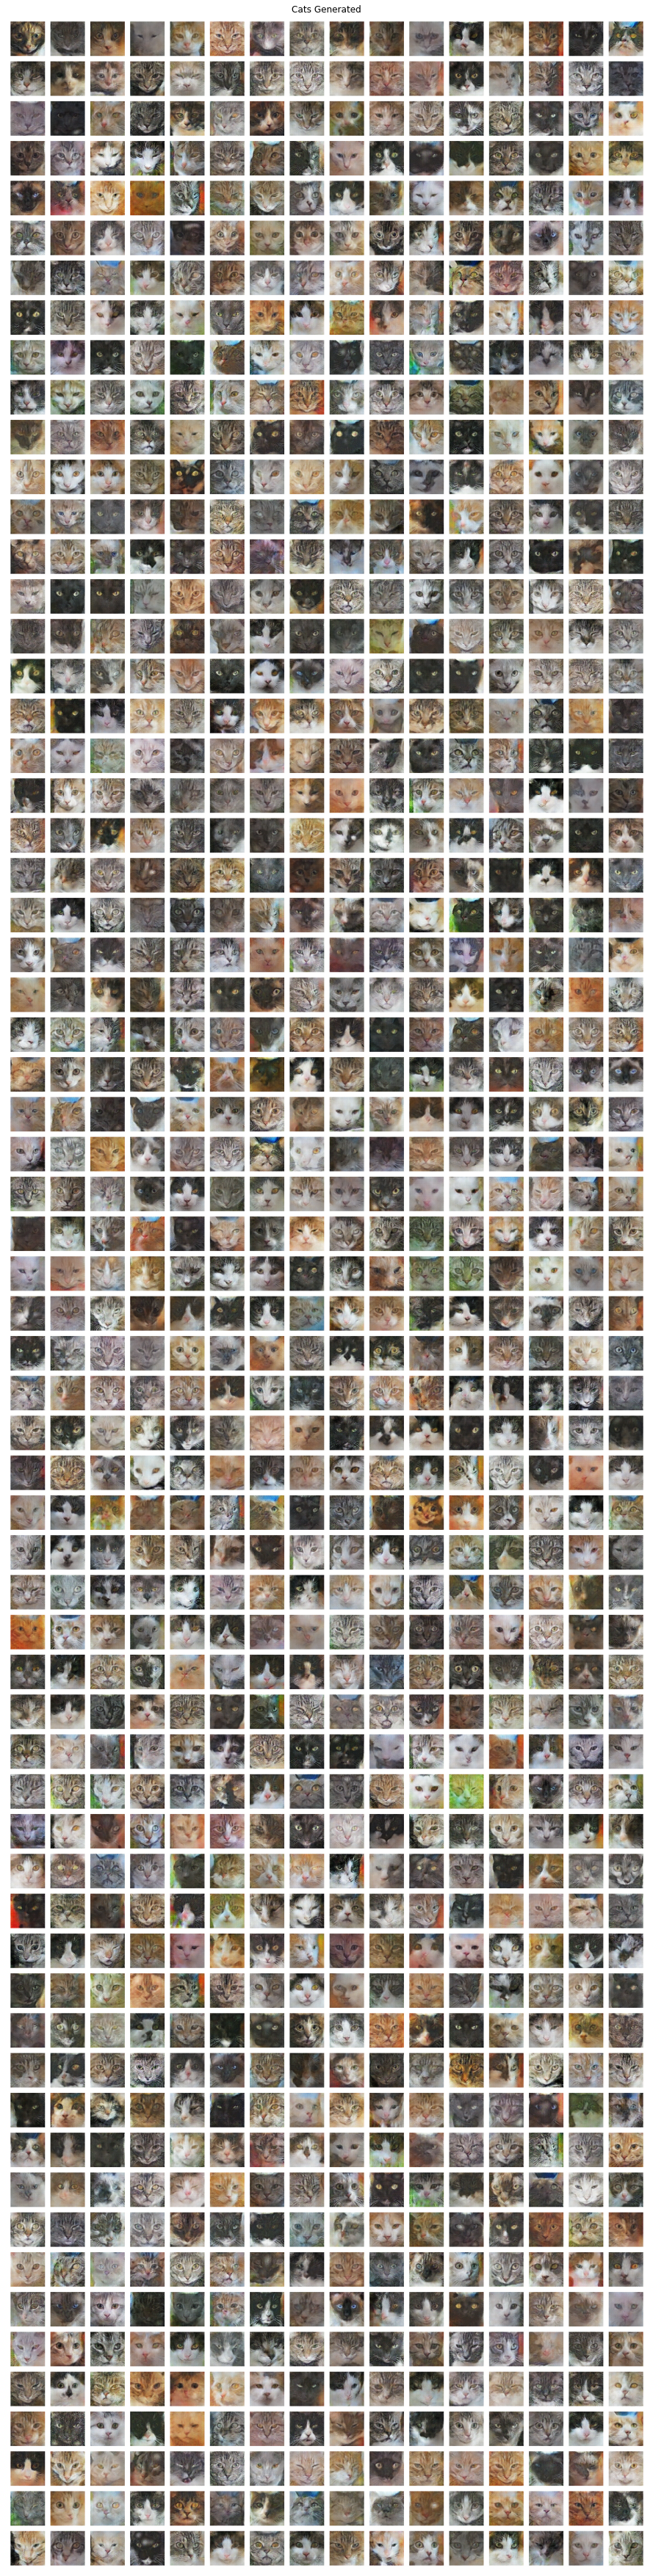

In [14]:
 z = torch.randn(1024, hparams['latent_dim'],1,1).to(device)
 with torch.no_grad():
     gen_imgs = generator(z).cpu()
gen_denorm = catGAN_T.denormalize(gen_imgs)
plot_cats(gen_denorm, images_per_row=16,border = 10, pad_value = 1, title="Cats Generated",figsize=(64,64))

## Metrics Evaluation
After the presentation professor Amerini said that having a matric of reference could be useful. So just for completeness I'm implementing it here. I'm using the FID (Fréchet inception distance) and the lower the value, the better since it is a distance. The FID metric is the current standard metric for assessing the quality of generative models as of 2020. It has been used to measure the quality of many recent models including the high-resolution StyleGAN1 and StyleGAN2 networks. Chong and Forsyth showed FID to be statistically biased, in the sense that their expected value over a finite data is not their true value. Also, because FID measured the Wasserstein distance towards the ground-truth distribution, it is inadequate for evaluating the quality of generators in domain adaptation setups, or in zero-shot generation. Finally, while FID is more consistent with human judgement than previously used inception score, there are cases where FID is inconsistent with human judgment (e.g. Figure 3,5 in Liu et al.).





In [15]:
!pip3 install pytorch-fid
fake_dir = "fake_imgs"
%mkdir {fake_dir}

for i in range(gen_denorm.shape[0]):
    torchvision.utils.save_image(gen_denorm[i],fake_dir+"/img_{}.jpg".format(i))
    
!python3 -m pytorch_fid "cats" "fake_imgs"

100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  9.49it/s]
FID:  31.20393534846545
